# ⚙️ **Set-up**

Run the following commands in the terminal:

```terminal
pip install numpy
pip install pandas
pip install openpyxl
pip install datetime
pip install matplotlib
pip install missingno
```

Run the code below to import packages needed for notebook:

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import missingno as msno

# :chart_with_upwards_trend: **Import raw data**

:warning: Ensure that the current working directory is in the main folder, e.g. named 'EC1B1'. 

- Inside the main folder, it contains a data folder named `data` 
- All the raw data are under the `data` folder, named `data_spain.xlsx` and `data_united_states.xlsx`
- This notebook is in the main folder as well

**Additional note:** We were unable to find the '_Exchange rates per US dollar (Period Average)_' data under the IMF database. Hence, we used exchange rate of USD per Peseta (Spain currency) instead.

In [4]:
# Import raw data
df_spain_raw = pd.read_excel('./data/data_spain.xlsx')
df_us_raw = pd.read_excel('./data/data_united_states.xlsx')

# Save them under new variables to keep raw data 'untouched'
df_spain = df_spain_raw
df_us = df_us_raw

We now take a quick inspect at the dataframe:

In [5]:
df_spain.head()

,International Financial Statistics (IFS),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,"Economic Activity, Industrial Production, Index","Exchange Rates, US Dollar per Domestic Currenc...","International Reserves and Liquidity, Reserves...","Prices, Consumer Price Index, All items, Index"
1,Jan 1960,NaN,0.016667,233,2.857368
2,Feb 1960,NaN,0.016667,253,2.855049
3,Mar 1960,NaN,0.016667,299,2.851573
4,Apr 1960,NaN,0.016667,326,2.853891


From raw data, we can tell that:
- Titles and headers are messy
- Years are not in `datetime` format
- Missing values
- Nominal exchange rate is currently not Perseta per US dollar, but the inverse

# :broom: **Basic cleaning**

### **For Spain:**

In the code below, there are several steps that we took to clean the data. The steps are labeled as `#Step`, and the rationale for each step is explained afterwards.

In [6]:
# Step 1
df_spain = df_spain.rename(columns={
    'International Financial Statistics (IFS)': 'date', 
    'Unnamed: 1': 'spain_industrial_index', 
    'Unnamed: 2': 'spain_nominal_exchange_rate', 
    'Unnamed: 3': 'spain_reserves', 'Unnamed: 4': 'spain_price_index'}
    ) [1:]

# Step 2
df_spain['spain_nominal_exchange_rate'] = 1 / df_spain['spain_nominal_exchange_rate']

# Step 3
df_spain['date'] = df_spain['date'].apply(lambda x: datetime.strptime(x, '%b %Y'))

# Step 4
df_spain.iloc[:, 1:] = df_spain.iloc[:, 1:].apply(pd.to_numeric).round(2)

<u>Explanation of steps:</u>
- **Step 1:** We rename the columns to more appropriate names, as well as removing the first row (which is irrelevant) using `[1:]`
- **Step 2:** We take the inverse of the exchange rate, since we are looking for 'exchange rate per US dollar'
- **Step 3:** Convert the dates into `datetime` format, using the function `strptime()` to match the date format
- **Step 4:** For all values except for the date column, we ensure that all datapoints are `numeric` and rounded to two decimal places

The cleaned dataframe should look as such:

In [7]:
df_spain.head()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index
1,1960-01-01,NaN,60.0,233.0,2.86
2,1960-02-01,NaN,60.0,253.0,2.86
3,1960-03-01,NaN,60.0,299.0,2.85
4,1960-04-01,NaN,60.0,326.0,2.85
5,1960-05-01,NaN,60.0,360.0,2.85


Note that there are `Nan` values in `spain_industrial_index` as some early data are not available (will be looked through in detail later)

### **For US:**

We follow similar steps for the US:

In [8]:
# Similar to Step 1 for Spain
df_us = df_us.rename(columns={
    'International Financial Statistics (IFS)': 'date',
    'Unnamed: 1': 'us_reserves',
    'Unnamed: 2': 'us_price_index'}) [1:]

# Similar to Step 2 for Spain
df_us['date'] = df_us['date'].apply(lambda x: datetime.strptime(x, '%b %Y'))

# Similar to Step 3 for Spain
df_us.iloc[:, 1:] = df_us.iloc[:, 1:].apply(pd.to_numeric).round(2)

# Inspect the dataframe
df_us.head()

,date,us_reserves,us_price_index
1,1960-01-01,21478.1,13.44
2,1960-02-01,21395.7,13.48
3,1960-03-01,21344.7,13.48
4,1960-04-01,21278.0,13.53
5,1960-05-01,21234.3,13.53


# :wrench: **Data manipulation**

We first merge both datasets:

In [9]:
# Merge based on 'date'
merged_df = pd.merge(df_spain, df_us, on = 'date')

# Inspect the new dataframe, tail() to show industrial index as well
merged_df.tail()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index
367,1990-08-01,57.14,97.03,53227.72,52.2,78908.84,60.35
368,1990-09-01,97.8,98.47,53790.19,52.75,80024.17,60.86
369,1990-10-01,100.91,95.7,55428.04,53.22,82852.2,61.22
370,1990-11-01,104.11,93.96,56347.86,53.17,83059.4,61.36
371,1990-12-01,88.2,95.23,56004.84,53.3,83316.21,61.36


We then create the lag variables based by requirements, `shift(1)` for monthly change and `shift(12)` for yearly:

In [11]:
# For Spain
merged_df['spain_nominal_exchange_rate_lag_1'] = merged_df['spain_nominal_exchange_rate'].shift(1)
merged_df['spain_price_index_lag_1'] = merged_df['spain_price_index'].shift(1)
merged_df['spain_industrial_index_lag_1'] = merged_df['spain_industrial_index'].shift(1)
merged_df['spain_industrial_index_lag_12'] = merged_df['spain_industrial_index'].shift(12)

# For US
merged_df['us_price_index_lag_1'] = merged_df['us_price_index'].shift(1)

# Data inspection
merged_df.tail()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,spain_industrial_index_lag_12,us_price_index_lag_1
367,1990-08-01,57.14,97.03,53227.72,52.2,78908.84,60.35,100.56,51.97,99.59,57.33,59.8
368,1990-09-01,97.8,98.47,53790.19,52.75,80024.17,60.86,97.03,52.2,57.14,100.16,60.35
369,1990-10-01,100.91,95.7,55428.04,53.22,82852.2,61.22,98.47,52.75,97.8,102.42,60.86
370,1990-11-01,104.11,93.96,56347.86,53.17,83059.4,61.36,95.7,53.22,100.91,103.92,61.22
371,1990-12-01,88.2,95.23,56004.84,53.3,83316.21,61.36,93.96,53.17,104.11,88.58,61.36


**<u>We create the rates of change, using the formulas:</u>**

For rate of change:

$$\text{Rate of Change (\%)} = \frac{{\text{Original Value} - \text{Lagged Value}}}{{\text{Lagged Value}}} \times 100$$

For real exchange rate:

$$\text{US to Spain Real Exchange Rate} = \text{US to Spain Nominal Exchange Rate} \times \frac{\text{US Price Level}}{{\text{Spain Price Level}}}$$

Finally, we apply these formulas to our code as such:

In [12]:
# Real exchange rate parts
merged_df['spain_real_exchange_rate'] = merged_df['spain_nominal_exchange_rate'] * merged_df['us_price_index'] / merged_df['spain_price_index']
merged_df['spain_real_exchange_rate_lag_1'] = merged_df['spain_real_exchange_rate'].shift(1)

# Applying rate of change formula
merged_df['spain_nominal_exchange_rate_growth'] = (merged_df['spain_nominal_exchange_rate'] - merged_df['spain_nominal_exchange_rate_lag_1']) / merged_df['spain_nominal_exchange_rate_lag_1'] * 100
merged_df['spain_real_exchange_rate_growth'] = (merged_df['spain_real_exchange_rate'] - merged_df['spain_real_exchange_rate_lag_1']) / merged_df['spain_real_exchange_rate_lag_1'] * 100
merged_df['spain_inflation_rate'] = (merged_df['spain_price_index'] - merged_df['spain_price_index_lag_1']) / merged_df['spain_price_index_lag_1'] * 100
merged_df['spain_industrial_growth'] = (merged_df['spain_industrial_index'] - merged_df['spain_industrial_index_lag_1']) / merged_df['spain_industrial_index_lag_1'] * 100
merged_df['spain_industrial_yearly_growth'] = (merged_df['spain_industrial_index'] - merged_df['spain_industrial_index_lag_12']) / merged_df['spain_industrial_index_lag_12'] * 100
merged_df['us_inflation_rate'] = (merged_df['us_price_index'] - merged_df['us_price_index_lag_1']) / merged_df['us_price_index_lag_1'] * 100

# Inspect the final output
merged_df.tail()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,spain_industrial_index_lag_12,us_price_index_lag_1,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate
367,1990-08-01,57.14,97.03,53227.72,52.2,78908.84,60.35,100.56,51.97,99.59,57.33,59.8,112.17932,115.710756,-3.510342,-3.051952,0.442563,-42.624762,-0.331415,0.919732
368,1990-09-01,97.8,98.47,53790.19,52.75,80024.17,60.86,97.03,52.2,57.14,100.16,60.35,113.609179,112.17932,1.484077,1.274619,1.05364,71.158558,-2.35623,0.84507
369,1990-10-01,100.91,95.7,55428.04,53.22,82852.2,61.22,98.47,52.75,97.8,102.42,60.86,110.085569,113.609179,-2.81304,-3.101519,0.890995,3.179959,-1.474321,0.591522
370,1990-11-01,104.11,93.96,56347.86,53.17,83059.4,61.36,95.7,53.22,100.91,103.92,61.22,108.433056,110.085569,-1.818182,-1.501117,-0.09395,3.171143,0.182833,0.228683
371,1990-12-01,88.2,95.23,56004.84,53.3,83316.21,61.36,93.96,53.17,104.11,88.58,61.36,109.630634,108.433056,1.351639,1.10444,0.244499,-15.281913,-0.428991,0.0


Finally, we create the reserve indexes. The index formula is as such:

$$\text{Index} = \frac{{\text{Current Value}}}{{\text{Index Value}}} \times 100$$

The 'Index Value' will be the first value of the reserve columns. The code is as such: 

In [13]:
# We first create empty lists for the indexes
spain_index_list = []
us_index_list = []

# We identify the initial values as the 'Index Value'
spain_first_value = merged_df.loc[0, 'spain_reserves']
us_first_value = merged_df.loc[0, 'us_reserves']

# For Spain – create a loop to calculate the index values for each value
for value in merged_df['spain_reserves']:
    if value != None: # Ensure that empty data, if any, is taken into consideration
        index = value / spain_first_value * 100 # Formula of index as above
    else:
        index = None

    spain_index_list.append(index)

# Similarly for US:
for value in merged_df['us_reserves']:
    if value != None:
        index = value / us_first_value * 100
    else:
        index = None

    us_index_list.append(index)

# Add new columns to the original dataframe
merged_df['spain_reserves_index_1960'] = spain_index_list
merged_df['us_reserves_index_1960'] = us_index_list

# Round all numeric values to two decimal places
merged_df = merged_df.round(2)

# Save as new variable
df = merged_df

# Finally, inspect the output
df.tail()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
367,1990-08-01,57.14,97.03,53227.72,52.2,78908.84,60.35,100.56,51.97,99.59,...,112.17932,115.710756,-3.510342,-3.051952,0.442563,-42.624762,-0.331415,0.919732,22844.52,367.39
368,1990-09-01,97.8,98.47,53790.19,52.75,80024.17,60.86,97.03,52.2,57.14,...,113.609179,112.17932,1.484077,1.274619,1.05364,71.158558,-2.35623,0.84507,23085.92,372.58
369,1990-10-01,100.91,95.7,55428.04,53.22,82852.2,61.22,98.47,52.75,97.8,...,110.085569,113.609179,-2.81304,-3.101519,0.890995,3.179959,-1.474321,0.591522,23788.86,385.75
370,1990-11-01,104.11,93.96,56347.86,53.17,83059.4,61.36,95.7,53.22,100.91,...,108.433056,110.085569,-1.818182,-1.501117,-0.09395,3.171143,0.182833,0.228683,24183.63,386.72
371,1990-12-01,88.2,95.23,56004.84,53.3,83316.21,61.36,93.96,53.17,104.11,...,109.630634,108.433056,1.351639,1.10444,0.244499,-15.281913,-0.428991,0.0,24036.41,387.91


As a double layer of check, we ran the following codes to inspect the columns as well as their types (delete the `#` if one wish to run the codes):

In [14]:
# df.columns

In [15]:
# df.dtypes

# :mag_right: **Inspection & fine-tuning**

### **Any missing values?**

Firstly, we utilise the `missingno` package to elegantly visualise any missing values:

<Axes: >

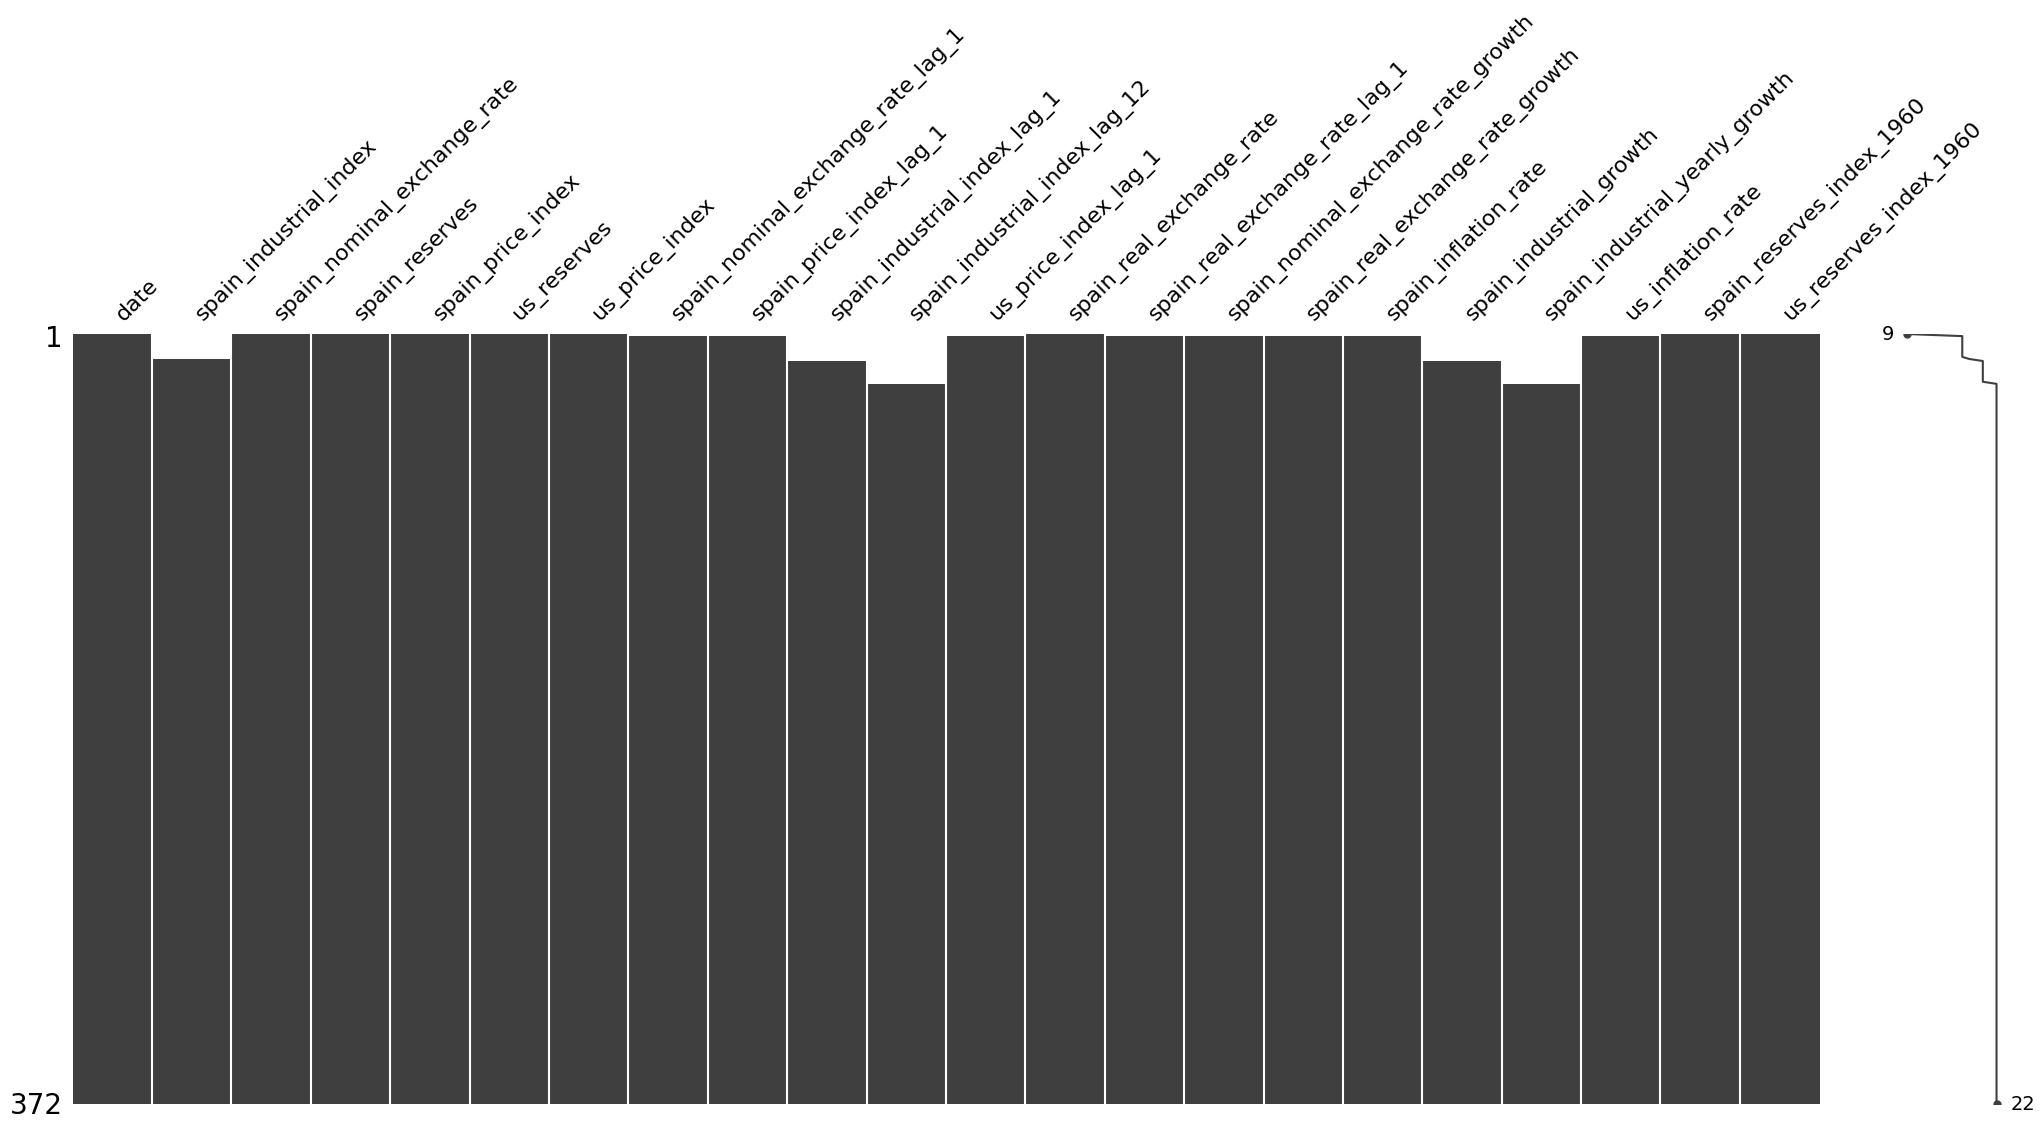

In [16]:
msno.matrix(df)

From the graph above, we can see that:
- Some variables have initial missing values
- There are no missing values in between
- On a closer inspection, only `_industrial_` columns have initial missing values

Since the values were missing in the raw data to begin with, we will leave the dataframe unchanged.

### **Any outliers?**

There are multiple ways to identify potential outliers. Before we decide on the method, we first ran the following code to plot each of the variables using histograms:

```python
for item in df.columns[1:]: # All variables except for 'date'
    plt.figure()
    plt.hist(df[item], bins=50, edgecolor='white')
    plt.title(str(item))
```
<u>Some observations:</u>
- Only a few distributions seem to be normal
- Some have some form of skewed distribution, some seems to have a uniform distribution for a certain range of values, others have distributions that seem very random

Therefore, in this case, the method of using standard deviation (considering values beyond a certain standard deviation as outliers) may not be appropriate. The method that we use is simply an empirical way of spotting extreme outliers ourselves from the distributions (there are not many of them).

<u>Variables that have outliers:</u>
- `spain_nominal_exchange_rate_growth`
- `spain_real_exchange_rate_growth`
- `spain_industrial_yearly_growth`
- `spain_inflation_rate`

For visualisation, we plot these variables:

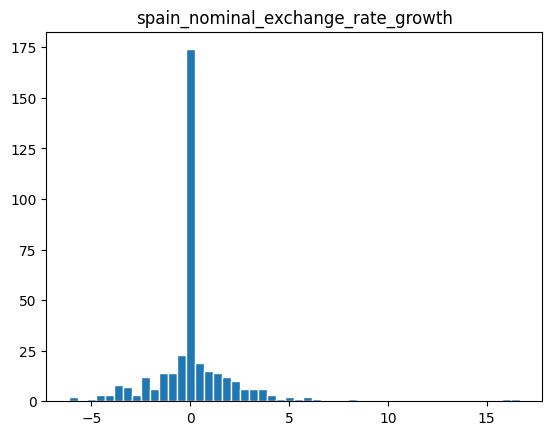

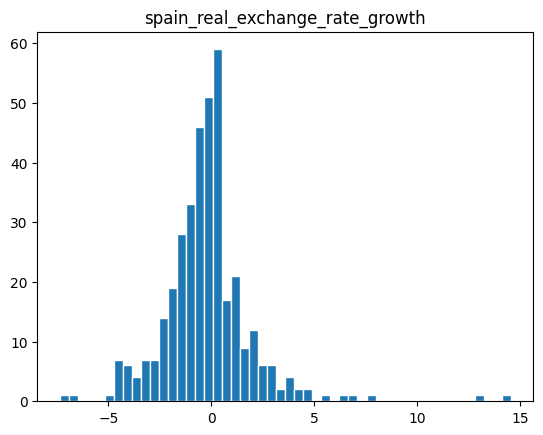

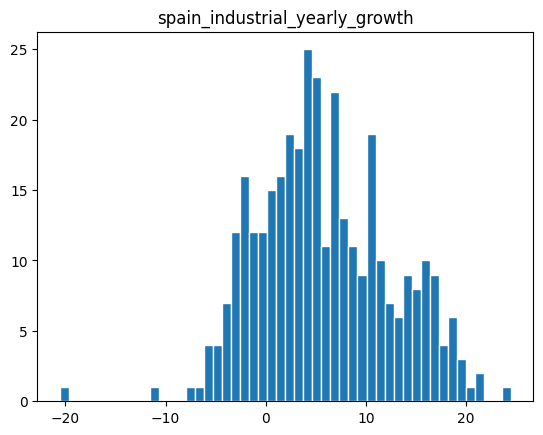

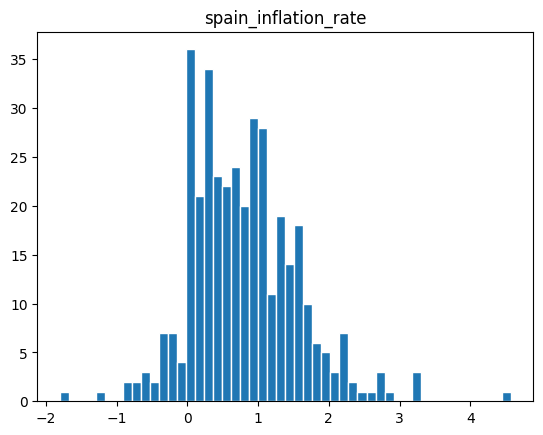

In [17]:
# Identify variables to inspect
factors_to_inspect = ['spain_nominal_exchange_rate_growth', 'spain_real_exchange_rate_growth', 'spain_industrial_yearly_growth', 'spain_inflation_rate']

# Plot each of the variable
for factor in factors_to_inspect:
    plt.figure()
    plt.hist(df[factor], bins=50, edgecolor='white')
    plt.title(str(factor))

To identify where the outliers exist in the dataframe, we build a custom function as such:

In [18]:
def determine_outlier_year(df, column_name, value, greater=True):
    '''
    parameters:
    df: the dataframe to inspect
    column_name: the variable to inspect
    value: the threshold value, determined empirically from histogram distribution, of outliers
    greater: set as 'True' for default (whether outliers are greater than/less than the threshold value)
    '''
    if greater:
        df_filtered = df[df[column_name] > value]
    else:
        df_filtered = df[df[column_name] <= value]

# We are only interested in the outlier rows
    return df_filtered

We first start with `spain_nominal_exchange_rate_growth` and `spain_real_exchange_rate_growth` (since they are closely correlated):

In [19]:
determine_outlier_year(df, 'spain_nominal_exchange_rate_growth', 15)

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
94,1967-11-01,37.19,70.0,1032.01,4.69,15437.6,15.5,60.0,4.59,35.99,...,231.343284,201.960784,16.666667,14.548616,2.178649,3.33426,1.639792,0.323625,442.92,71.88
210,1977-07-01,71.54,80.52,4634.96,13.49,18926.99,27.97,69.31,13.06,77.19,...,166.949177,147.748116,16.173712,12.995807,3.292496,-7.319601,-3.558911,0.466954,1989.25,88.12


In [20]:
determine_outlier_year(df, 'spain_real_exchange_rate_growth', 10)

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
94,1967-11-01,37.19,70.0,1032.01,4.69,15437.6,15.5,60.0,4.59,35.99,...,231.343284,201.960784,16.666667,14.548616,2.178649,3.33426,1.639792,0.323625,442.92,71.88
210,1977-07-01,71.54,80.52,4634.96,13.49,18926.99,27.97,69.31,13.06,77.19,...,166.949177,147.748116,16.173712,12.995807,3.292496,-7.319601,-3.558911,0.466954,1989.25,88.12


The outliers are in years 1967 and 1977. Upon further research:
- **(1959)** Spanish peseta's nominal exchange rate changed from 60 to 70 USD. This adjustment was part of Spain's efforts to stabilize its currency and manage its exchange rate within the framework of the Bretton Woods system.
  - <u>Classify as outlier</u> (one-time increase, endogenously influenced by policy)
- **(1977)** Spain was transitioning from the dictatorship of Francisco Franco to a democratic system. Uncertainty around Spain's political transition had an economic spillover effect, including high inflation rates and an unstable exchange rate.
  - <u>Do not classify as outlier</u> (natural exogenous events)

Now we inspect `spain_industrial_yearly_growth`:

In [21]:
determine_outlier_year(df, 'spain_industrial_yearly_growth', -15, greater=False)

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
187,1975-08-01,46.41,58.33,6485.82,9.27,16116.68,24.9,57.25,9.12,66.46,...,156.679288,156.056469,1.886463,0.399098,1.644737,-30.168522,-20.544427,0.160901,2783.61,75.04


Finally, we inspect `spain_inflation_rate`:

In [22]:
determine_outlier_year(df, 'spain_inflation_rate', 4)

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
196,1976-05-01,74.84,67.63,5528.04,10.75,17955.33,25.91,67.27,10.28,73.42,...,163.004028,168.371313,0.535157,-3.187767,4.571984,1.934078,6.579322,0.699572,2372.55,83.6


# 📊 **Graphic visualisation**

# **5.3.1**

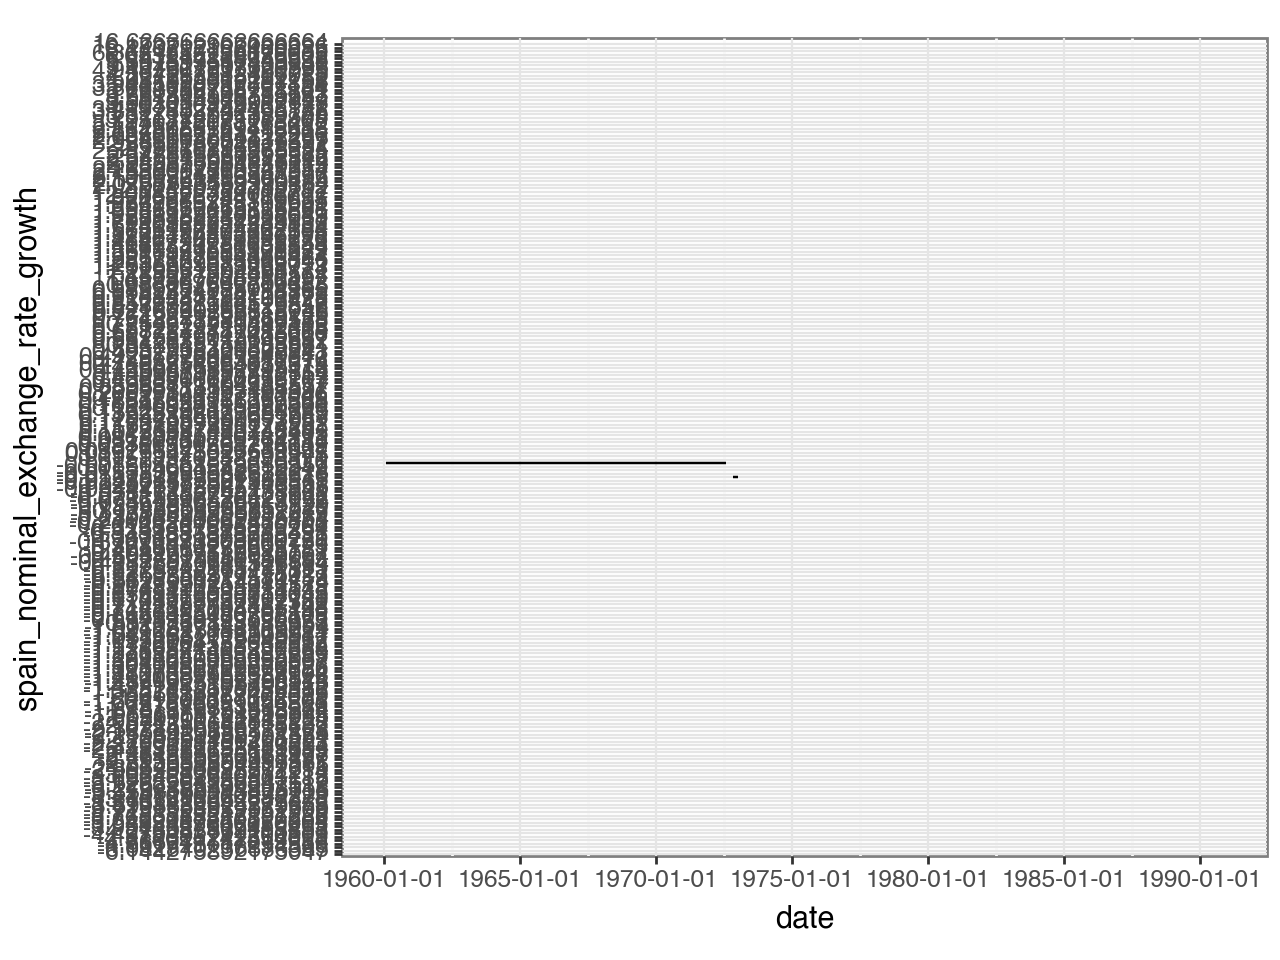

<Figure Size: (640 x 480)>

In [23]:
from plotnine import *


# Plot the data
g = (
    ggplot(df, aes(x='date', y='spain_nominal_exchange_rate_growth')) + 
    geom_line() + 
    theme_bw()
)

g

Text(0.5, 1.0, 'Spain Nominal Exchange Rate Growth Over Time')

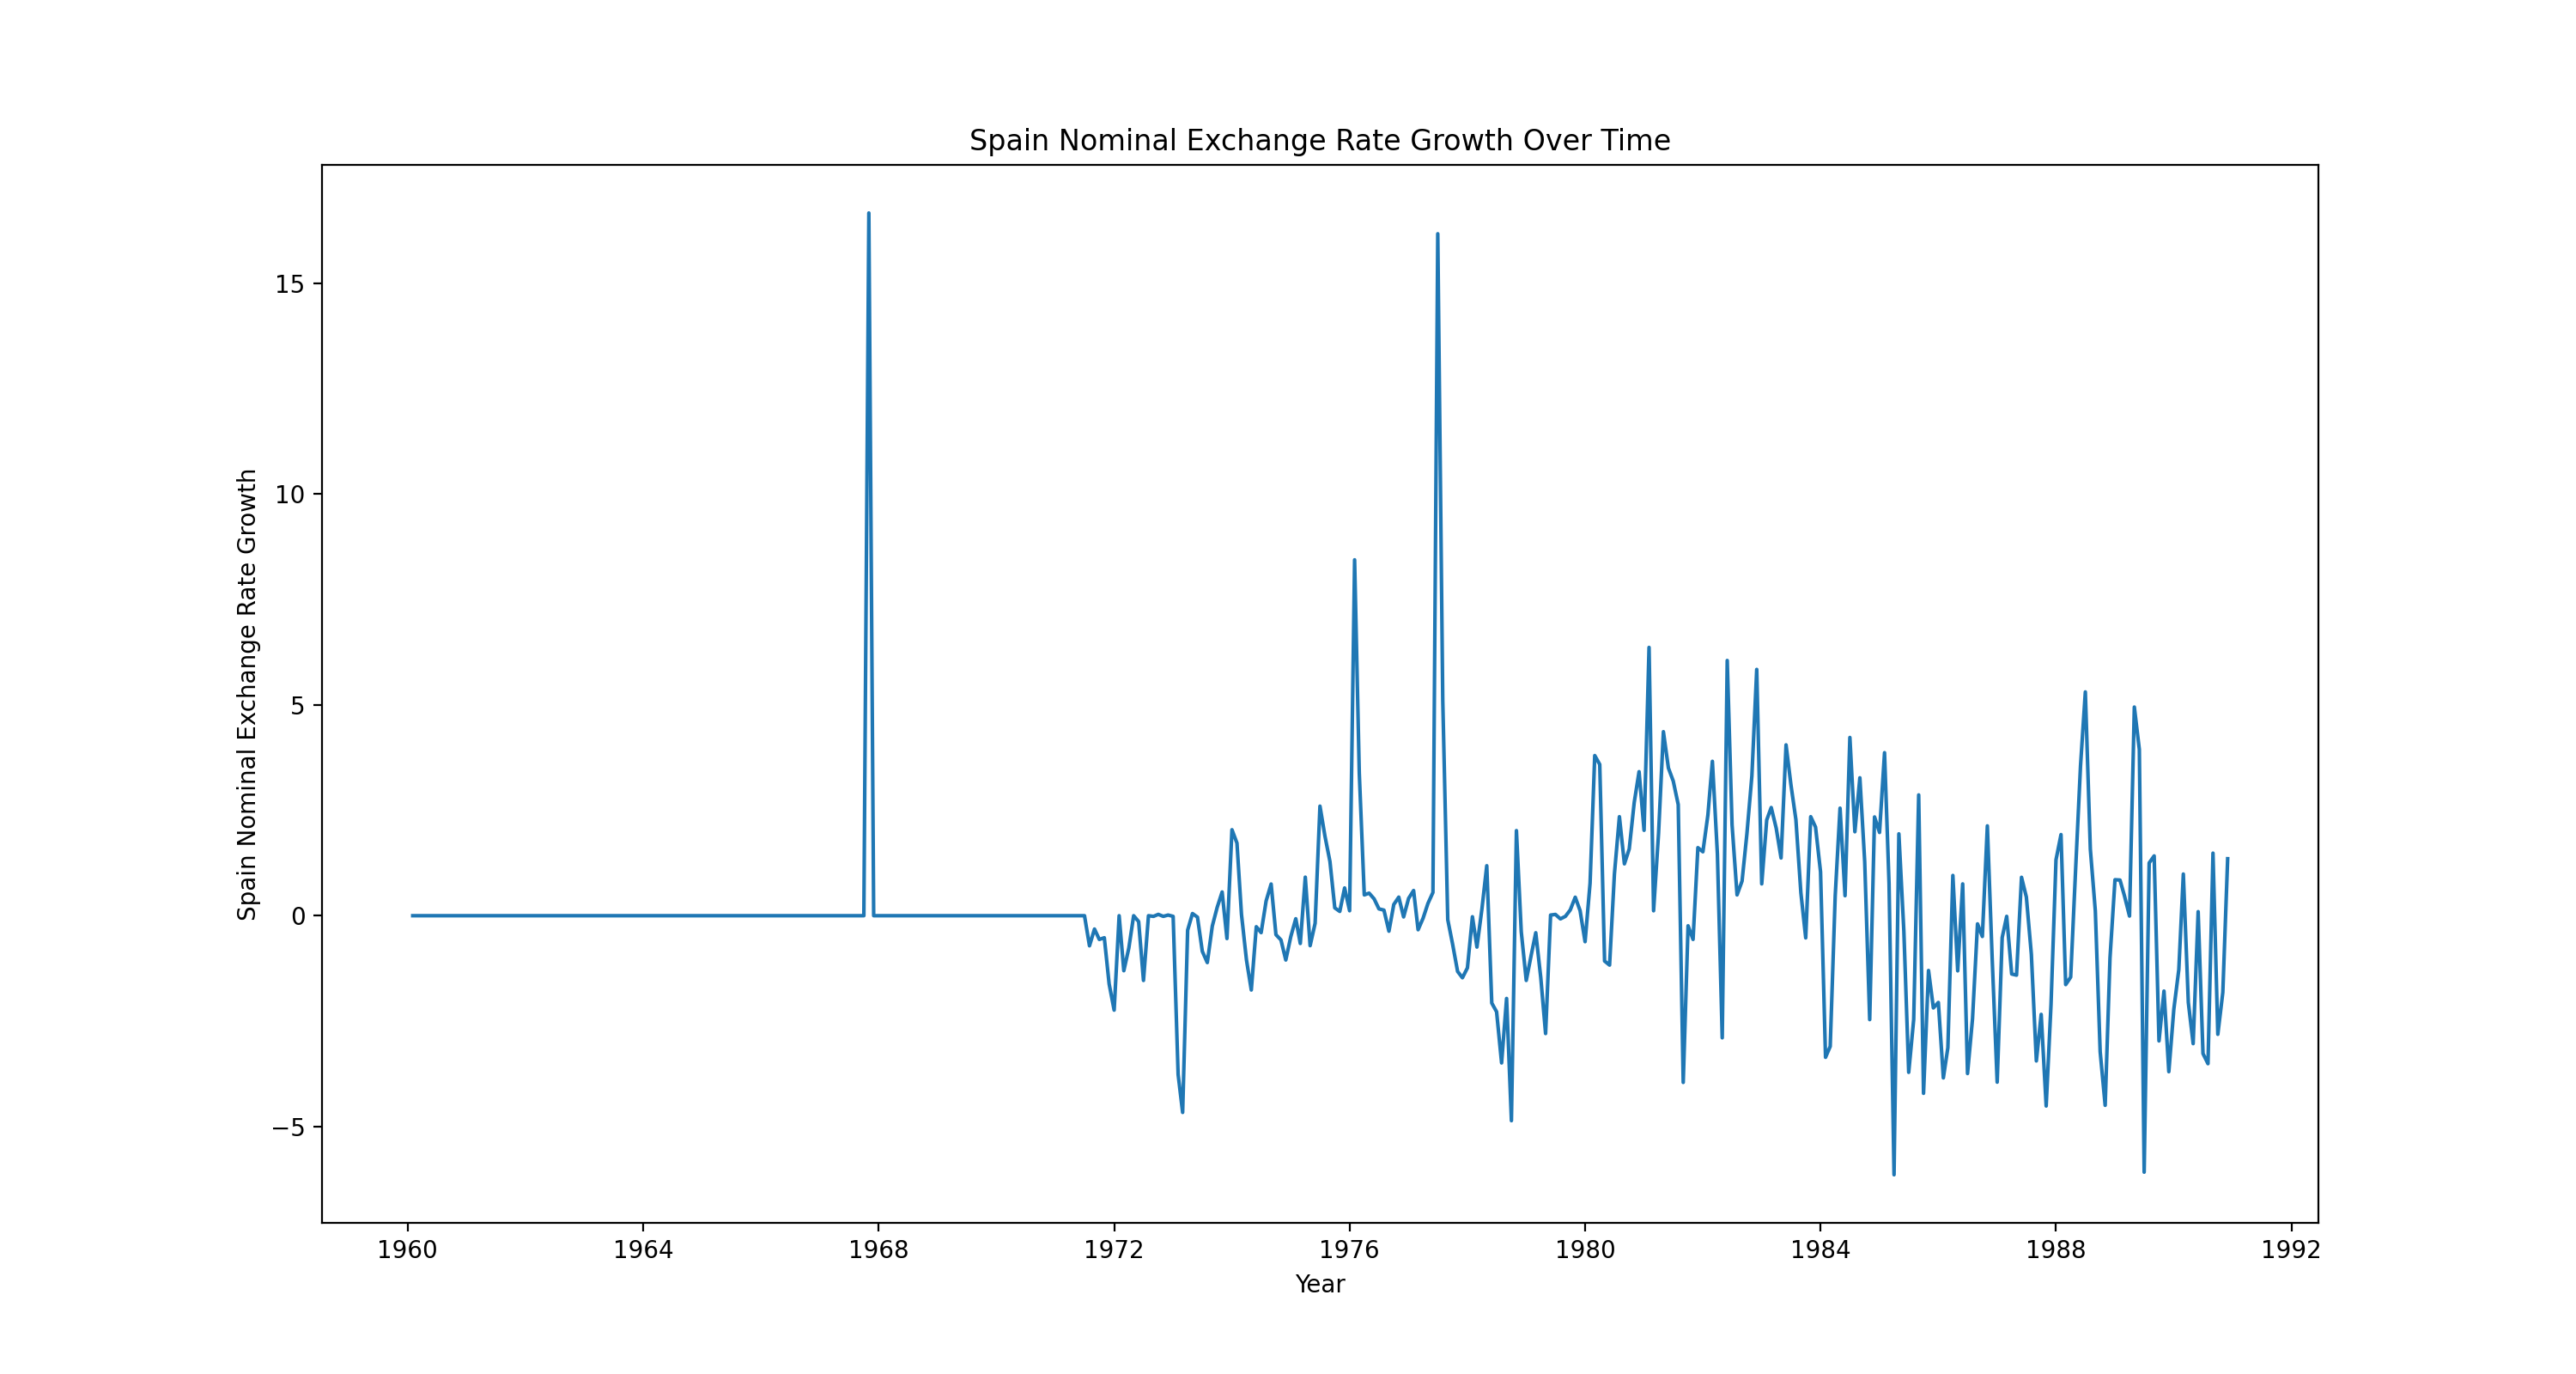

In [24]:
plt.figure(figsize = (15, 8))
plt.plot(df['date'], df['spain_nominal_exchange_rate_growth'])
plt.xlabel('Year')
# plt.xticks(rotation=45, fontweight='bold')
plt.ylabel('Spain Nominal Exchange Rate Growth')
plt.title('Spain Nominal Exchange Rate Growth Over Time')

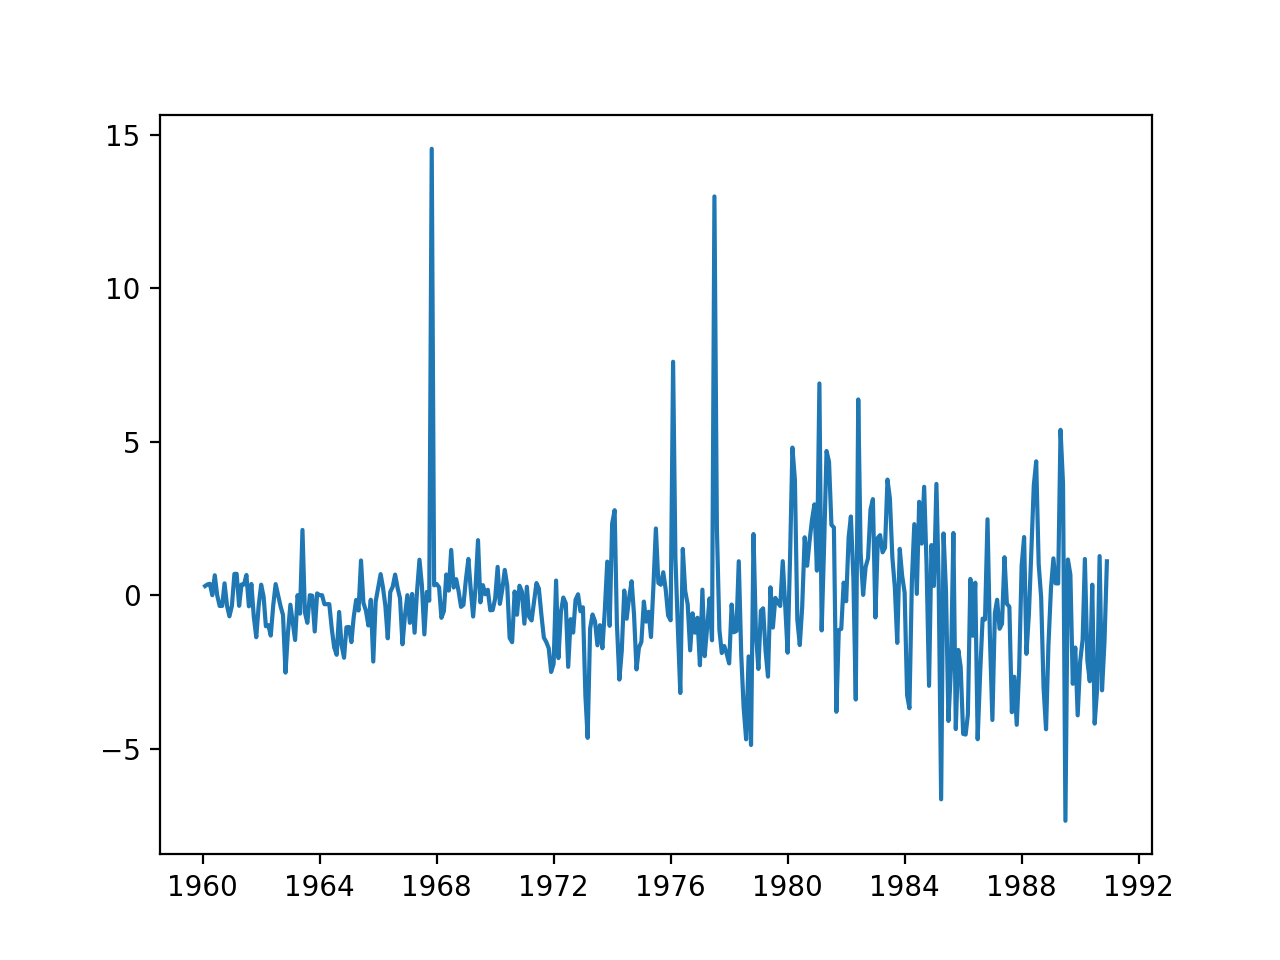

In [25]:
plt.plot(df['date'], df['spain_real_exchange_rate_growth'])

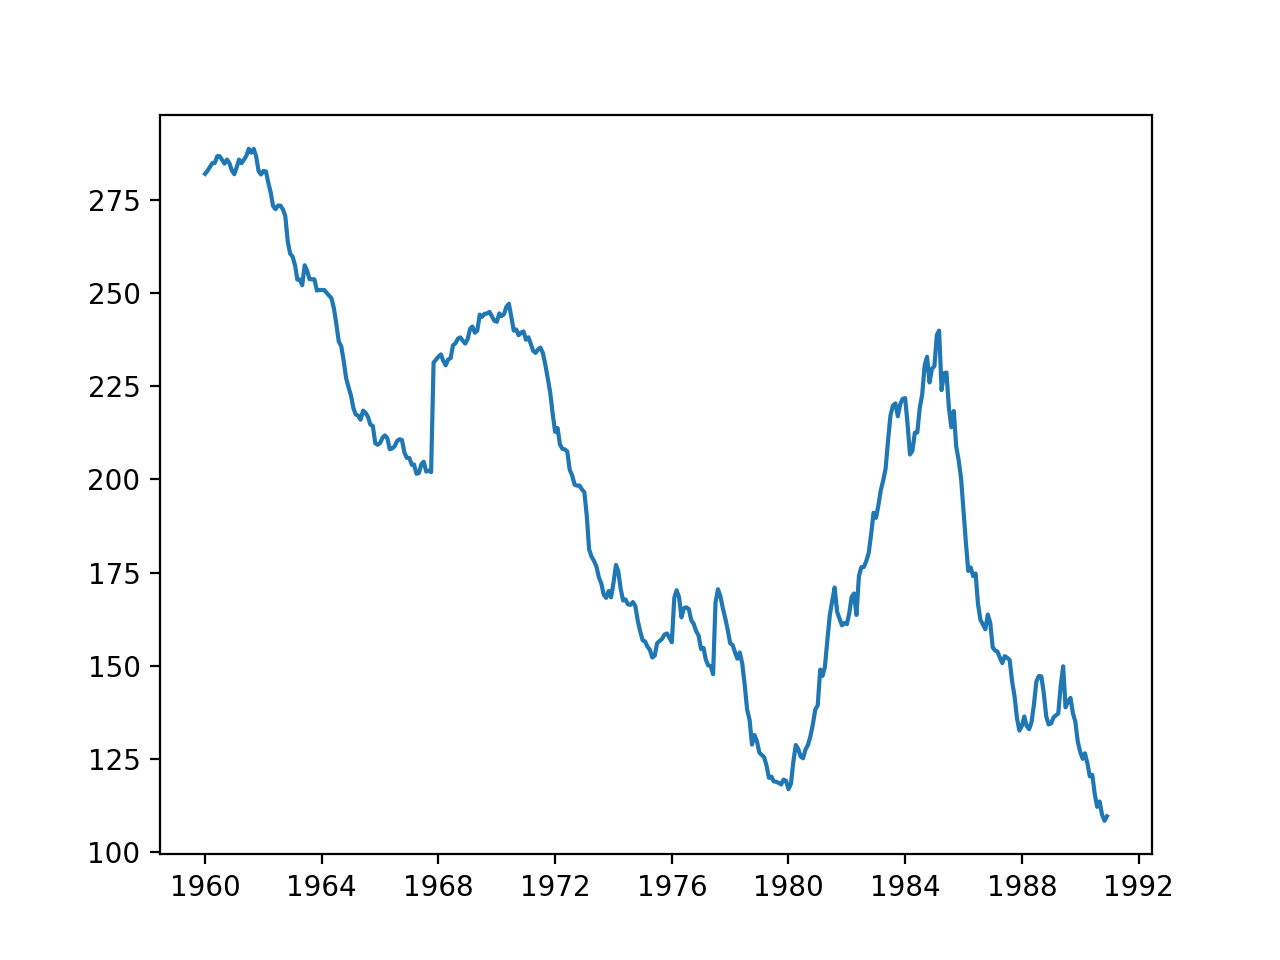

In [26]:
plt.plot(df['date'], df['spain_real_exchange_rate'])

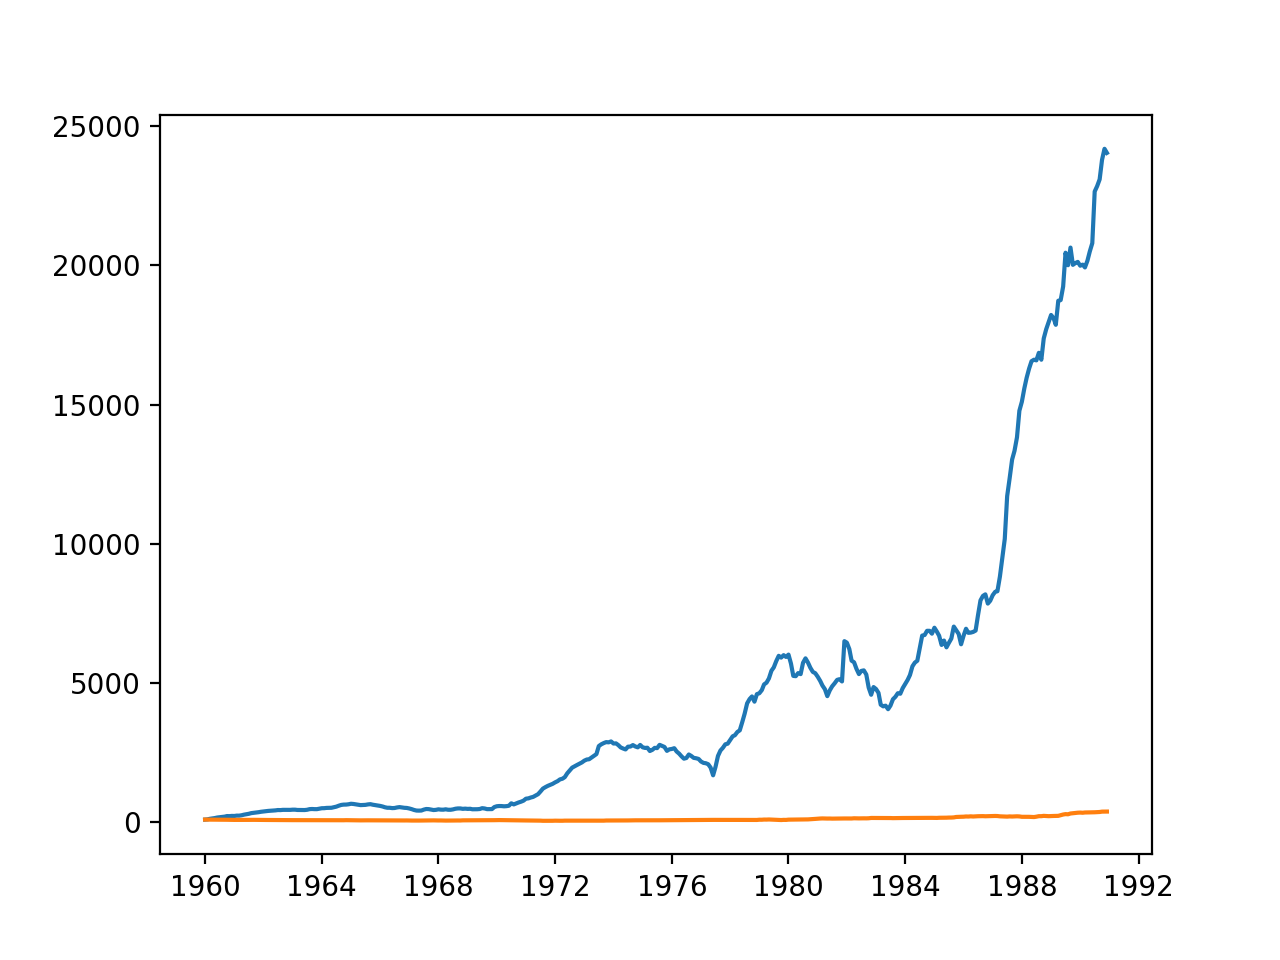

In [27]:
# Remember change to until 1973
plt.plot(df['date'], df['spain_reserves_index_1960'])
plt.plot(df['date'], df['us_reserves_index_1960'])

# **5.3.2**

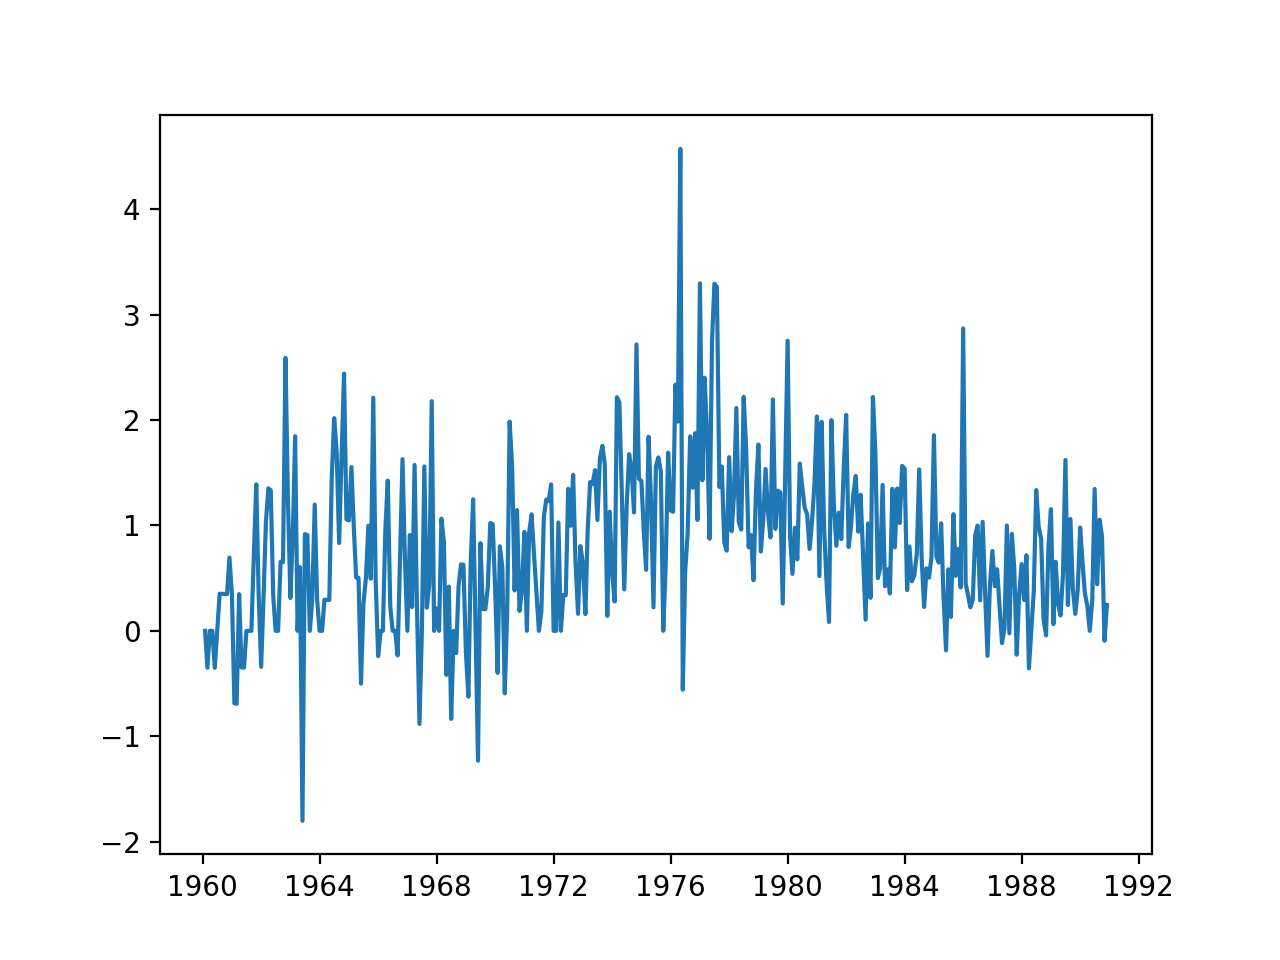

In [28]:
plt.plot(df['date'], df['spain_inflation_rate'])

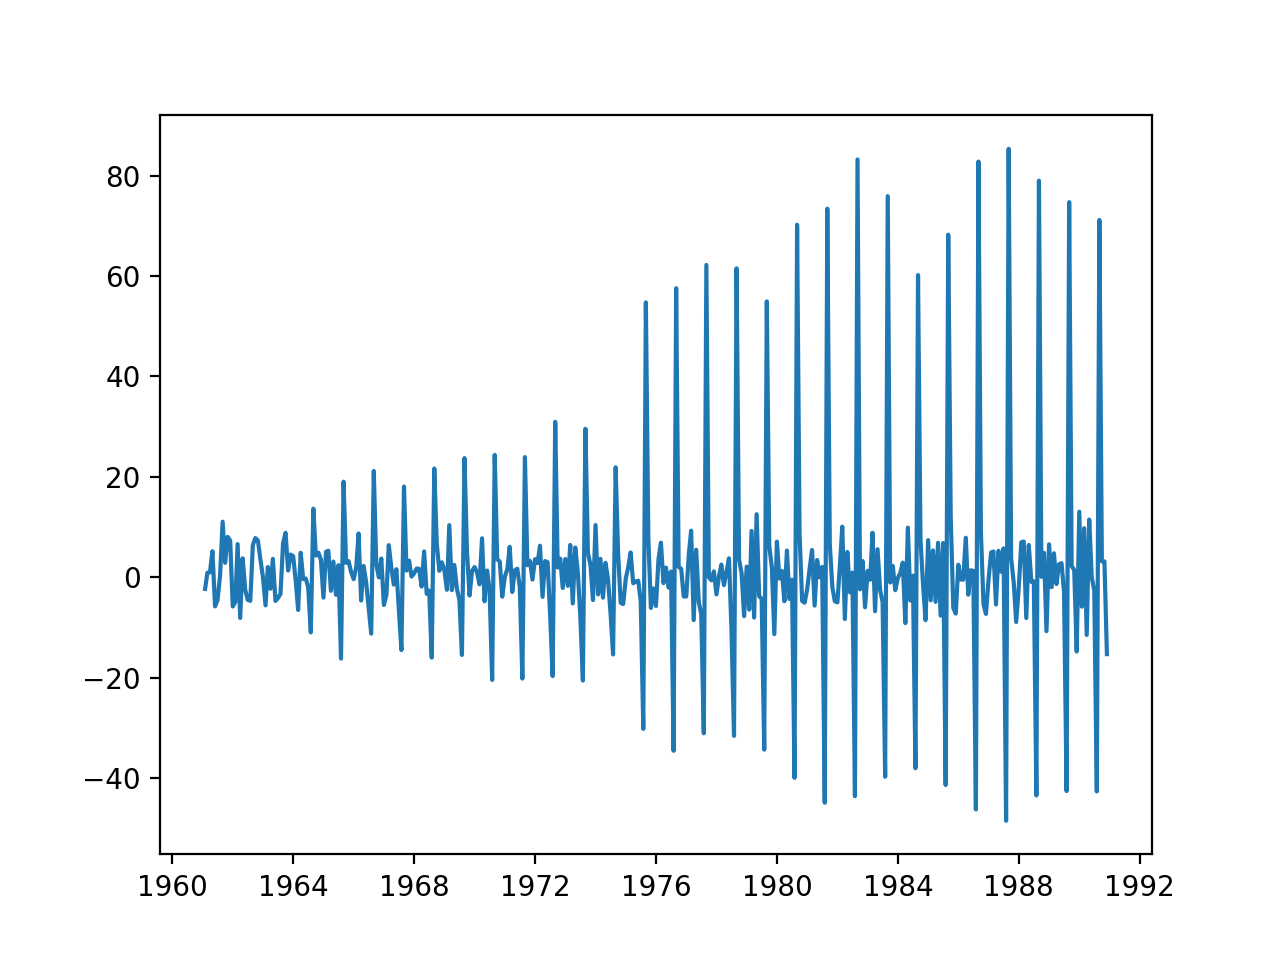

In [29]:
plt.plot(df['date'], df['spain_industrial_growth'])

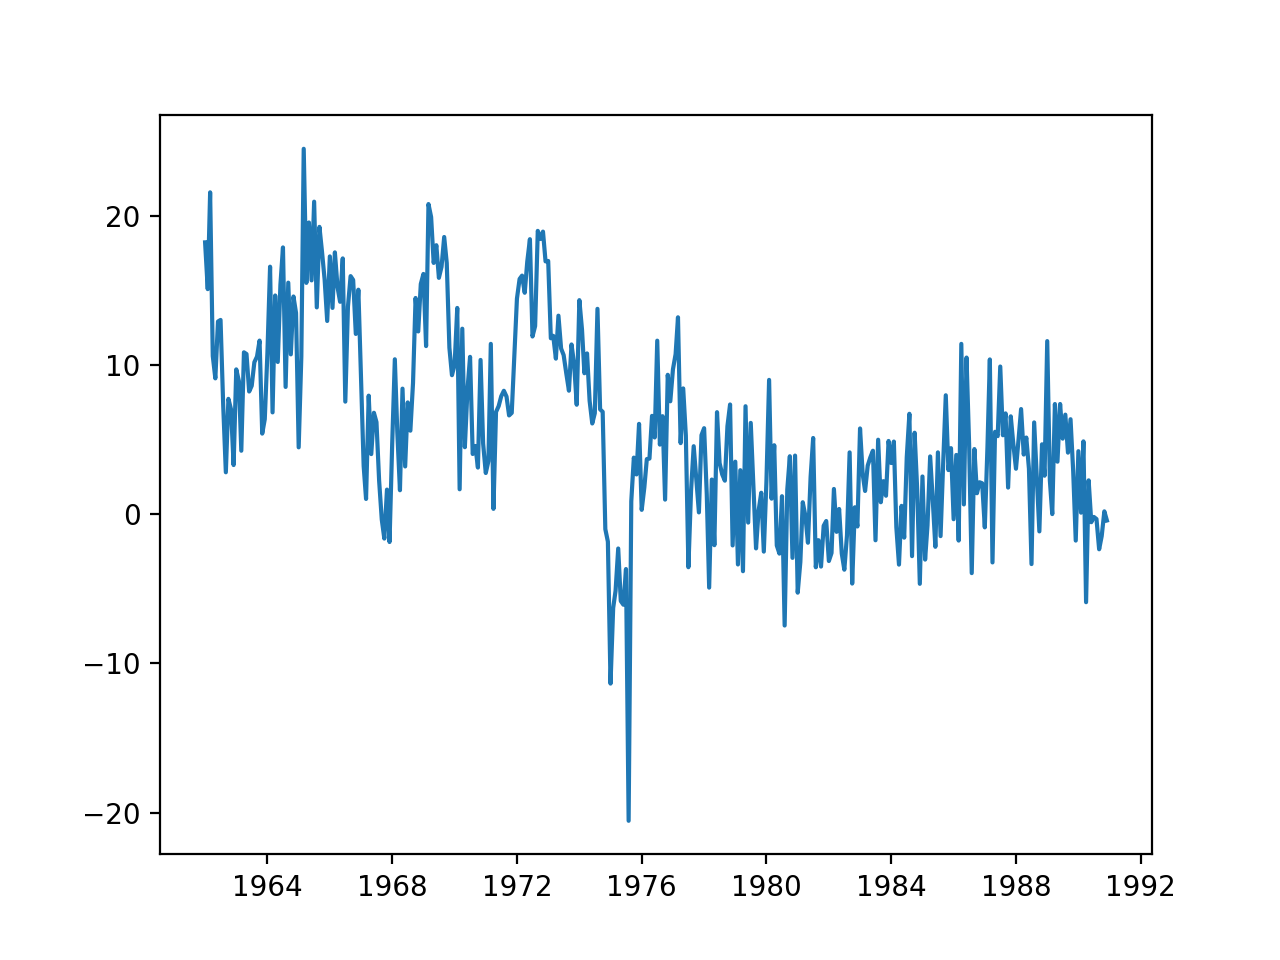

In [30]:
plt.plot(df['date'], df['spain_industrial_yearly_growth'])

# **5.3.3**

In [31]:
df['us_minus_spain_inflation'] = df['us_inflation_rate'] - df['spain_inflation_rate']

In [32]:
df_before = df[df['date'] <= pd.to_datetime('1971-07-01')]
df_after = df[df['date'] >= pd.to_datetime('1973-01-01')]

In [33]:
std_factors = ['spain_nominal_exchange_rate_growth', 'spain_real_exchange_rate_growth', 'spain_inflation_rate', 'us_minus_spain_inflation', 'spain_industrial_yearly_growth']

std_values = {'before': {}, 'after': {}}

for dataframe in [df_before, df_after]:
    for factor in std_factors:
        factor_std = dataframe[factor].std()  # Calculate standard deviation and round to two decimal places
        std_values['before' if dataframe is df_before else 'after'][factor] = factor_std  # Store standard deviation with factor name as key

# Convert std_values dictionary to DataFrame
std_df = pd.DataFrame(std_values)
std_df['ratio (after/before)'] = std_df['after'] / std_df['before']
std_df = std_df.round(2)

print("Standard deviations:")
print(std_df)

Standard deviations:
                                    before  after  ratio (after/before)
spain_nominal_exchange_rate_growth    1.42   2.58                  1.82
spain_real_exchange_rate_growth       1.48   2.53                  1.72
spain_inflation_rate                  0.73   0.74                  1.02
us_minus_spain_inflation              0.79   0.75                  0.95
spain_industrial_yearly_growth        5.69   5.05                  0.89
